# PyMC Wrapper

> Wrapper to unify the generation of pymc marketing priors

In [ ]:
#| default_exp wrapper/pymc_wrapper

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from __future__ import annotations

from abc import ABC, abstractmethod
from typing import Protocol, Callable, Tuple

import numpy as np
import xarray as xr
import pymc as pm
import pytensor.tensor as pt
from pymc_marketing.prior import handle_dims
from pymc_marketing.prior import Prior as _Prior
from pymc_marketing.mmm.hsgp import (
    HSGP as _HSGP, 
    HSGPPeriodic as _HSGPPeriodic
)
from pymc_marketing.mmm.fourier import (
    WeeklyFourier as _WeeklyFourier,
    MonthlyFourier as _MonthlyFourier,
    YearlyFourier as _YearlyFourier
)


In [ ]:
#| export
class _GeneralPrior(ABC):
    """Generalized prior interface for pymc-marketing. This generalizes the use of the apply method to any prior.
    """
    def __init__(
        self, 
        name: str, 
        **kwargs
        ):
        self.name = name

    @abstractmethod
    def apply(
        self, 
        data: xr.DataArray | pt.TensorLike | None, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        raise NotImplementedError

    def __add__(
        self, 
        other: _GeneralPrior
        ) -> _SumPrior:
        return _SumPrior(
            [
                self, 
                other
            ], 
            name=f"{self.name}+{other.name}"
        )

    def __mul__(
        self, 
        other: _GeneralPrior
        ) -> _ProductPrior:
        return _ProductPrior(
            [
                self, 
                other
            ], 
            name=f"{self.name}*{other.name}")

    def __call__(
        self, 
        node: _GeneralPrior
        ) -> _GeneralPrior:
        return _AppliedNode(
            f"{self.name}({node.name})", 
            self, 
            node
        )


In [ ]:
#| export
class _CombPrior(_GeneralPrior):
    def __init__(
        self, 
        children: list[GeneralPrior], 
        name: str, 
        agg_fn: Callable
        ):
        super().__init__(name)
        self.children = children
        self.agg_fn = agg_fn
        self._dims = tuple(
            set(
                dim for dims in [child._dims for child in self.children] for dim in dims
            )
        )

    def apply(
        self, 
        data: xr.DataArray | pt.TensorLike, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        
        with model:
            self.children[0].apply(data)
            for _child in (self.children[1:]):
                _child.apply(data)
            self._variable = pm.Deterministic(
                self.name,
                self.agg_fn(
                    [
                        handle_dims(child._variable, child._dims, self._dims)
                        for child in self.children
                    ]
                ),
                dims=self._dims,
            )
        return self._variable

In [ ]:
#| export
class _SumPrior(_CombPrior):
    def __init__(
        self, 
        children: list[_GeneralPrior], 
        name: str
        ):
        super().__init__(children, name, sum)

In [ ]:
#| export
class _ProductPrior(_CombPrior):
    def __init__(
        self, 
        children: list[_GeneralPrior], 
        name: str
        ):
        super().__init__(children, name, np.prod)

In [ ]:
#| export
class _AppliedPrior(_GeneralPrior):
    def __init__(
        self, 
        name: str, 
        caller_node: _GeneralPrior, 
        input_node: _GeneralPrior
        ):
        super().__init__(name)
        self._caller_node = caller_node
        self._input_node = input_node
        self._dims = caller_node._dims

    def apply(
        self, 
        data: xr.DataArray | pt.TensorLike | None, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)

        with model: 
            self._variable = self._caller_node.apply(self._input_node.apply(data), model=model)
        
        return self._variable

In [ ]:
#| export
class HSGP(_GeneralPrior):
    def __init__(
        self, 
        name: str,
        **kwargs
        ):
        super().__init__(name)
        self._gp = _HSGP(**kwargs)
        self._dims = self._gp.dims
        
    
    def __getattr__(self, name: str):
        if hasattr(self._gp, name):
            return getattr(self._gp, name)
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

    def apply(
        self,
        data: xr.DataArray | pt.TensorLike | None, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        with model:
            self._variable = self._gp.register_data(data).create_variable(self.name)
        return self._variable

In [ ]:
hspg = HSGP(
    "hspg",
    m=40,
    ls=1,
    eta=3,
    L=60,
    dims=("date",)
)

In [ ]:
#| export
class HSGPPeriodic(_GeneralPrior):
    def __init__(
        self, 
        name: str,
        **kwargs
        ):
        super().__init__(name)
        self._gp = _HSGPPeriodic(**kwargs)
        self._dims = self._gp.dims
        
    
    def __getattr__(self, name: str):
        if hasattr(self._gp, name):
            return getattr(self._gp, name)
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

    def apply(
        self,
        data: xr.DataArray | pt.TensorLike | None, 
        model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        with model:
            self._variable = self._gp.register_data(data).create_variable(self.name)
        return self._variable

In [ ]:
#| export
class YearlyFourier(_GeneralPrior):
    def __init__(self, name: str, **kwargs):
        super().__init__(name)
        kwargs |= {'prefix': name}
        self._fourier = _YearlyFourier(**kwargs)
        self._dims = kwargs.get("dims", ("date",))

    def __getattr__(self, name: str):
        if hasattr(self._fourier, name):
            return getattr(self._fourier, name)
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")
    
    def apply(
        self, data: xr.DataArray | pt.TensorLike | None, model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        with model:
            self._variable = pm.Deterministic(
                self.name, self._fourier.apply(data), dims=self._dims
            )
        return self._variable

In [ ]:
yearly_fourier = YearlyFourier(
    name="yearly_fourier",
    n_order=3,
    dims=("date",),
)

In [ ]:
#| eval: false
#| output: asis
show_doc(yearly_fourier.sample_prior)

---

### FourierBase.sample_prior

>      FourierBase.sample_prior (coords:dict|None=None, **kwargs)

*Sample the prior distributions.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| coords | dict \| None | None | Coordinates for the prior distribution, by default None |
| kwargs | VAR_KEYWORD |  | Additional keywords for sample_prior_predictive |
| **Returns** | **Dataset** |  | **Prior distribution.** |

In [ ]:
#| eval: false
#| output: asis
show_doc(yearly_fourier.sample_curve)

---

### FourierBase.sample_curve

>      FourierBase.sample_curve (parameters:arviz.data.inference_data.InferenceD
>                                ata|xarray.core.dataset.Dataset,
>                                use_dates:bool=False,
>                                start_date:str|datetime.datetime|None=None)

*Create full period of the Fourier seasonality.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| parameters | arviz.data.inference_data.InferenceData \| xarray.core.dataset.Dataset |  | Inference data or dataset containing the Fourier parameters.<br>Can be posterior or prior. |
| use_dates | bool | False | If True, use datetime coordinates for the x-axis. Defaults to False. |
| start_date | str \| datetime.datetime \| None | None | Starting date for the Fourier curve. If not provided and use_dates is True,<br>it will be derived from the current year or month. Defaults to None. |
| **Returns** | **DataArray** |  | **Full period of the Fourier seasonality.** |

Sampling: [yearly_fourier_beta]
Sampling: []


Output()

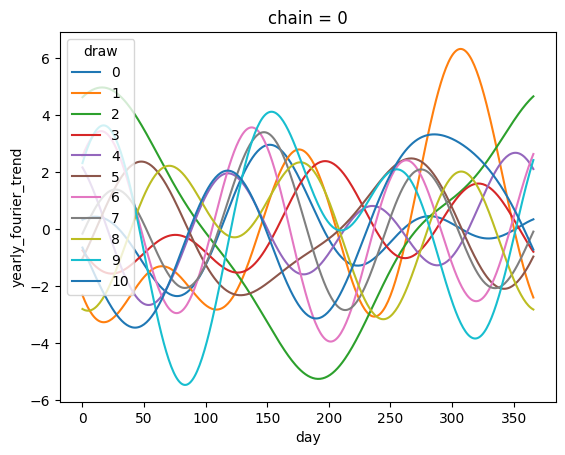

In [ ]:
prior_sample = yearly_fourier.sample_prior()
curve_sample = yearly_fourier.sample_curve(prior_sample)
curve_sample.sel(chain=0, draw=slice(10)).plot(x='day', hue='draw');

In [ ]:
#| export
class Prior(_GeneralPrior):
    def __init__(self, name: str, **kwargs):
        super().__init__(name)
        self._prior = _Prior(**kwargs)
        self._dims = prior.dims

    def apply(
        self,
        data: xr.DataArray | pt.TensorLike | None = None,
        model: pm.Model | None = None,
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        with model:
            self._variable = self._prior.create_variable(self.name)
        return self._variable

    def __getattr__(self, name: str):
        if hasattr(self._prior, name):
            return getattr(self._prior, name)
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

In [ ]:
#| export
class Data(_GeneralPrior):
    def __init__(self, name: str, dims: Tuple[str] | None = None):
        super().__init__(name)
        self._dims = dims

    def apply(
        self, data: xr.DataArray | pt.TensorLike, model: pm.Model | None = None
    ) -> pt.TensorLike:
        model = pm.modelcontext(model)
        with model:
            self._variable = pm.Data(self.name, data, dims=self._dims)
        return self._variable

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()